<a href="https://colab.research.google.com/github/nikhil-mathews/MastersPr_Predicting-Human-Pathogen-PPIs-using-Natural-Language-Processing-methods/blob/main/4.Final_model/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
#Google colab does not have pickle
try:
  import pickle5 as pickle
except:
  !pip install pickle5
  import pickle5 as pickle
import os
import seaborn as sns

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,Concatenate
from keras.models import Model,load_model
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve, auc
from numpy import random
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.metrics import AUC

import sys
sys.path.insert(0,'/content/drive/MyDrive/ML_Data/')
import functions as f

In [ ]:
def load_data(D=1,randomize=False):
    try:
        with open('/content/drive/MyDrive/ML_Data/df_train_'+str(D)+'D.pickle', 'rb') as handle:
            df_train = pickle.load(handle)
    except:
        df_train = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-train.pkl")
    try:
        with open('/content/drive/MyDrive/ML_Data/df_test_'+str(D)+'D.pickle', 'rb') as handle:
            df_test = pickle.load(handle)
    except:
        df_test = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-independent.pkl")
    if randomize:
        return shuff_together(df_train,df_test)
    else:
        return df_train,df_test

# df_train,df_test = load_data(5)
# print('The data used will be:')
# df_train

df_train,df_test = load_data()
df_train

,Human,Yersinia,Joined,label
0,"[M, K, D, K, Q, K, K, K, K, E, R, T, W, A, E, ...","[M, A, K, A, S, R, H, N, L, S, I, G, I, S, M, ...","[M, K, D, K, Q, K, K, K, K, E, R, T, W, A, E, ...",1
1,"[M, S, W, S, G, L, L, H, G, L, N, T, S, L, T, ...","[M, Q, H, V, T, G, S, K, R, R, L, I, G, W, V, ...","[M, S, W, S, G, L, L, H, G, L, N, T, S, L, T, ...",0
2,"[M, S, L, F, D, L, F, R, G, F, F, G, F, P, G, ...","[M, A, E, L, P, A, K, R, R, F, T, R, I, D, R, ...","[M, S, L, F, D, L, F, R, G, F, F, G, F, P, G, ...",1
3,"[M, A, V, A, P, R, L, F, G, G, L, C, F, R, F, ...","[M, R, I, F, A, I, S, C, S, S, Y, T, Y, C, Y, ...","[M, A, V, A, P, R, L, F, G, G, L, C, F, R, F, ...",0
4,"[M, S, T, I, Q, S, E, T, D, C, Y, D, I, I, E, ...","[M, S, Y, A, F, P, G, T, F, P, G, R, R, M, R, ...","[M, S, T, I, Q, S, E, T, D, C, Y, D, I, I, E, ...",0
...,...,...,...,...
6265,"[M, S, Y, F, G, E, H, F, W, G, E, K, N, H, G, ...","[M, I, T, T, D, G, N, S, A, V, A, S, V, A, Y, ...","[M, S, Y, F, G, E, H, F, W, G, E, K, N, H, G, ...",1
6266,"[M, T, V, G, K, S, S, K, M, L, Q, H, I, D, Y, ...","[M, S, Q, P, P, F, W, Q, Q, K, T, L, A, E, M, ...","[M, T, V, G, K, S, S, K, M, L, Q, H, I, D, Y, ...",1
6267,"[M, N, N, L, S, F, S, E, L, C, C, L, F, C, C, ...","[M, S, E, D, R, H, Q, Q, R, Q, Q, R, L, K, E, ...","[M, N, N, L, S, F, S, E, L, C, C, L, F, C, C, ...",0
6268,"[M, A, P, E, I, N, L, P, G, P, M, S, L, I, D, ...","[M, K, N, L, S, F, V, A, G, L, V, I, L, L, G, ...","[M, A, P, E, I, N, L, P, G, P, M, S, L, I, D, ...",1


In [ ]:
trains = f.preprocess(df_train)
tests = f.preprocess(df_test)

Converting to 5D. This will take a few minutes
Create tokenizers? Enter y if this is new training data. y/n: y
Saved tokenizers as doubleip_tkrs
Saved tokenizer as join_tkr
Preprocessing...
Converting to 5D. This will take a few minutes
Create tokenizers? Enter y if this is new training data. y/n: n
Preprocessing...


In [ ]:
EMBEDDING_DIM_5D = 25
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 1
DROP = 0.5
threshold = 0.918
MAX_SEQUENCE_LENGTH_5D_J = 2000
MAX_SEQUENCE_LENGTH_5D_dIP = 1000
num_words_5D_J = 1000000
num_words_5D = 500000

for i in range(10):


  x1_join = f.transf_model(MAX_SEQUENCE_LENGTH_5D_J,num_words_5D_J,5,0.9)
  x2_join = f.transf_model(MAX_SEQUENCE_LENGTH_5D_J,num_words_5D_J,5,0.9)
  x3_join = f.transf_model(MAX_SEQUENCE_LENGTH_5D_J,num_words_5D_J,5,0.9)

  x1_doubleip = f.conv_model(MAX_SEQUENCE_LENGTH_5D_dIP,EMBEDDING_DIM_5D,num_words_5D,DROP)
  x2_doubleip = f.conv_model(MAX_SEQUENCE_LENGTH_5D_dIP,EMBEDDING_DIM_5D,num_words_5D,DROP)
  x3_doubleip = f.conv_model(MAX_SEQUENCE_LENGTH_5D_dIP,EMBEDDING_DIM_5D,num_words_5D,DROP)
  x4_doubleip = f.conv_model(MAX_SEQUENCE_LENGTH_5D_dIP,EMBEDDING_DIM_5D,num_words_5D,DROP)
  x5_doubleip = f.conv_model(MAX_SEQUENCE_LENGTH_5D_dIP,EMBEDDING_DIM_5D,num_words_5D,DROP)
  x6_doubleip = f.conv_model(MAX_SEQUENCE_LENGTH_5D_dIP,EMBEDDING_DIM_5D,num_words_5D,DROP)

  concatenator = Concatenate(axis=1)
  x = concatenator([x1_join.output, x2_join.output, x3_join.output, x1_doubleip.output, x2_doubleip.output, x3_doubleip.output, x4_doubleip.output, x5_doubleip.output, x6_doubleip.output])
  x = Dense(256)(x)
  x = Dropout(0.5)(x)
  output = Dense(1, activation="sigmoid",name="Final")(x)
  model_final = Model(inputs=[x1_join.input, x2_join.input, x3_join.input, x1_doubleip.input, x2_doubleip.input, x3_doubleip.input, x4_doubleip.input, x5_doubleip.input, x6_doubleip.input], outputs=output)

  model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=AUC())

  model_final.fit(trains, df_train['label'].values, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(tests,df_test['label'].values))
  score = roc_auc_score(df_test['label'].values, model_final.predict(tests))
  score = round(score,3)
  print("Score is",score)
  if score>threshold:
    threshold = score
    print('Saving model_final_'+str(score)+'')
    model_final.save('/content/drive/MyDrive/ML_Data/model_final_'+str(i)+'_'+str(score)+'')
  #print(roc_auc_score(df_test['label'].values, model_final.predict(tests)))

196/196 [==============================] - 198s 897ms/step - loss: 0.6066 - auc: 0.7454 - val_loss: 0.4305 - val_auc: 0.9107
Score is 0.911
196/196 [==============================] - 187s 922ms/step - loss: 0.6017 - auc_1: 0.7639 - val_loss: 0.3808 - val_auc_1: 0.9123
Score is 0.912
196/196 [==============================] - 186s 917ms/step - loss: 0.6176 - auc_2: 0.7404 - val_loss: 0.3918 - val_auc_2: 0.9134
Score is 0.913
196/196 [==============================] - 182s 895ms/step - loss: 0.5987 - auc_3: 0.7546 - val_loss: 0.3868 - val_auc_3: 0.9161
Score is 0.916
196/196 [==============================] - 187s 920ms/step - loss: 0.6389 - auc_4: 0.7258 - val_loss: 0.3854 - val_auc_4: 0.9190
Score is 0.919
Saving model_final_0.919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_Data/model_final_4_0.919/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_Data/model_final_4_0.919/assets


196/196 [==============================] - 187s 921ms/step - loss: 0.5789 - auc_5: 0.7687 - val_loss: 0.4024 - val_auc_5: 0.9156
Score is 0.916
196/196 [==============================] - 183s 900ms/step - loss: 0.6012 - auc_6: 0.7512 - val_loss: 0.4221 - val_auc_6: 0.9092
Score is 0.909
196/196 [==============================] - 181s 894ms/step - loss: 0.6487 - auc_7: 0.7222 - val_loss: 0.3773 - val_auc_7: 0.9133
Score is 0.913
196/196 [==============================] - 181s 897ms/step - loss: 0.5959 - auc_8: 0.7564 - val_loss: 0.4004 - val_auc_8: 0.9078
Score is 0.908
196/196 [==============================] - 190s 936ms/step - loss: 0.5977 - auc_9: 0.7549 - val_loss: 0.3855 - val_auc_9: 0.9098
Score is 0.91


In [ ]:
name = 'model_final_4_0.919'
model = load_model('/content/drive/MyDrive/ML_Data/final_models/'+name)
roc_auc_score(df_test['label'].values, model.predict(tests))

0.9189877305431124

In [ ]:
lengths = []
for i in range(df_test.shape[0]):
  lengths.append(len(df_test[['Joined']].iloc[i][0]))

s = sorted(lengths)
print("median test Joined sequences length:", s[len(s) // 2])

small_seq = df_test.loc[[i for i, x in enumerate(lengths) if x < 500]].reset_index(drop=True)
y_small_seq = df_test['label'].loc[[i for i, x in enumerate(lengths) if x < 500]].reset_index(drop=True)
big_seq = df_test.loc[[i for i, x in enumerate(lengths) if x > 1500]].reset_index(drop=True)
y_big_seq = df_test['label'].loc[[i for i, x in enumerate(lengths) if x > 1500]].reset_index(drop=True)
small_seq.shape,big_seq.shape

median test Joined sequences length: 893


((233, 4), (280, 4))

In [ ]:
roc_auc_score(y_small_seq.values, model.predict(f.preprocess(small_seq,saveTokrs=False)))

Preprocessing...


0.9144423753362301

In [ ]:
roc_auc_score(y_big_seq.values, model.predict(f.preprocess(big_seq,saveTokrs=False)))

Preprocessing...


0.898819320214669

Preprocessing...
Preprocessing...


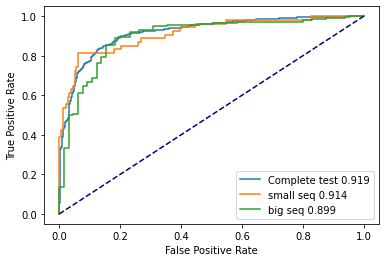

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
plt.plot(fpr, tpr, label='Complete test 0.919')
fpr, tpr, thresholds = roc_curve(y_small_seq, model.predict(f.preprocess(small_seq,saveTokrs=False)))
plt.plot(fpr, tpr, label='small seq 0.914')
fpr, tpr, thresholds = roc_curve(y_big_seq, model.predict(f.preprocess(big_seq,saveTokrs=False)))
plt.plot(fpr, tpr, label='big seq 0.899')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()